In [1]:
import paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
import h5py
import GPy
import drawSvg as draw

 /Users/yeun260/Library/Python/3.8/lib/python/site-packages/drawSvg/raster.py:18: RuntimeWarning:Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': dlopen(libcairo.so.2, 2): image not found
cannot load library 'libcairo.2.dylib': dlopen(libcairo.2.dylib, 2): image not found
cannot load library 'libcairo-2.dll': dlopen(libcairo-2.dll, 2): image not found


In [2]:
amps = True
if amps:
    from cklemap.sdfs.darcy import DarcyExp
    from cklemap.sdfs.dasa import DASAExpKLAMPS
    import cklemap.ckli.mapest as mapest
else:
    from cklemap.sdfs.darcy_old import DarcyExp
    from cklemap.sdfs.dasa_old import DASAExpKL
    import cklemap.ckli.mapest_old as mapest

In [3]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    #fig.colorbar(p, ax=ax)
    return p

In [4]:
# Parameters
res_fac = 1
resolution = '1x'
resolution_iYobs = '16x'
num_trials = 1
seed = 0
#Nuobs = 50
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nens = 5000
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
lsq_method = 'trf'
draw_field = False
data_path = '../data/'
results_path = '../results/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'RF1/conduct_log_RF1_{resolution}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
ref = "Yref=orig"

In [5]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

with h5py.File(conduct_filename, 'r') as f:
    Yref = f.get('conduct_log')[:].ravel() - Yfac

In [6]:
prob = DarcyExp(TPFA(geom, bc))
uref = prob.solve(Yref)

In [7]:
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1

Nuobs = iuobs.size
uobs = uref[iuobs]

In [8]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [9]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [10]:
if os.path.exists(yobs_filename):
    print(f"iYobs read from file {yobs_filename}")
    iYobs_fine = np.load(yobs_filename)
    if iYobs_fine.shape[0] < num_trials:
        print("iYobs randomly generated")
        iYobs = rs.choice(Yref.size, NYobs, replace=False)
    geom_fine = GeomMRST(geom_fine_filename)
else:
    print("iYobs randomly generated")
    iYobs = rs.choice(Yref.size, NYobs, replace=False)
    np.save(yobs_filename, iYobs)

iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])

iYobs read from file ../data/yobs/yobs_100_16x.npy


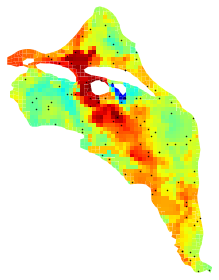

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_patch(patches, Yref + Yfac, fig, ax, geom.cells.centroids[:, iYobs[0]], 'Yref', 0, 12)
fig.tight_layout()
#fig.savefig(f'hanford/figures/Yref_NY={NYobs}_1x_from_4x.pdf', dpi=300)

In [12]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_gamma={gamma_map}_cklmap_h1reg_{amps=}_{ref}'
print(exp)

NY=100_Nu=323_NYlearn=100_NYxi=1000_gamma=1e-06_cklmap_h1reg_amps=True_Yref=orig


In [13]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))

Yest = np.zeros((num_trials, Nc))

In [16]:
for t in range(num_trials):
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0006   1.837728e+02   2.073321e+03 
    00s05  0012   1.499870e+02   1.070512e+00 
    00s08  0020   1.487627e+02   2.502102e-01 
    00s09  0021   1.487560e+02   3.094093e-02 
    00s12  0028   1.487508e+02   1.509072e-04 
    00s15  0037   1.487508e+02   5.562569e-08 
Runtime:     00s15
Optimization status: Converged

GPR: [0.37225787] s


In [17]:
Ym = Ypred
CYm = CYpred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.5555053]
GPR	Infinity error: [5.84266437]


In [18]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [1.60820117] s


In [19]:
# CKL-MAP H1 estimate
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpKLAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs, Ym[t], PsiY[t])
    else:
        dasa = DASAExpKL(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t])
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(NYxi), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest[t] = Ym[t] + PsiY[t] @ sol.x
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'CKL-MAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest[t], Yref) for t in range(num_trials)])

print(f"CKL-MAP: {timings[:, 4]} s")
print(f"CKL-MAP relative L2 error: {rel_errors[:, 2]}")
print(f"CKL-MAP absolute infinity error: {abs_errors[:, 2]}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.4220e+01                                    3.42e+01    
       1              2         1.5528e+01      4.87e+01       1.00e+00       8.53e+00    
       2              3         3.3249e+00      1.22e+01       2.00e+00       7.71e-01    
       3              4         4.4733e-01      2.88e+00       4.00e+00       1.71e+00    
       4              5         1.5555e-01      2.92e-01       8.00e+00       1.47e+00    
       5              6         2.4556e-02      1.31e-01       8.00e+00       6.74e-01    
       6              8         2.5933e-03      2.20e-02       4.00e+00       9.21e-02    
       7             10         1.4693e-03      1.12e-03       2.00e+00       1.54e-02    
       8             11         1.0630e-03      4.06e-04       4.00e+00       6.88e-02    
       9             12         9.2925e-04      1.34e-04       4.00e+00       8.60e-02    

In [ ]:
if draw_field:
    hex_colors = np.array([colors.to_hex(cm.get_cmap('jet')(colors.Normalize(0, 12)(Yref + Yfac))[t]) for t in range(Nc)])
    vertices = np.around(geom.nodes.coords.T[geom.cells.nodes.T, :], 4)

    d = draw.Drawing(1, 1)
    d.setRenderSize(1000, 1000)
    g = draw.Group(stroke_width=0.001, stroke='black')
    g.append(draw.Animate('fill-opacity', '4s', '0; 0; 1', keyTimes="0; 0.5; 1", fill='remove', id='seq_0'))
    g.append(draw.Animate('stroke-opacity', '2s', to='0', begin='2s', fill='freeze'))
    n, m = vertices.shape[:-1]
    v = np.empty((m + 1, m + 1), dtype=object)
    for j in range(n):
        p = draw.Path(fill=hex_colors[j]).M(*vertices[j, 0, :])
        v[:-1, 0] = np.repeat('M{},-{}'.format(*vertices[j, 0, :]), m)
        for i in range(1, m):
            p.L(*vertices[j, i, :])
            for k in range(i):
                v[k, i] = ' L{},-{}'.format(*vertices[j, k, :])
            for k in range(i, m):
                v[k, i] = ' L{},-{}'.format(*vertices[j, i, :])
        for k in range(m):
            v[k, m] = ' L{},-{}'.format(*vertices[j, k, :])
            v[m, k] = v[m - 1, k]
        v[m, m] = ' L{},-{}'.format(*vertices[j, 0, :])
        p.appendAnim(draw.Animate('d', '2s', ';\n'.join([''.join(r) for r in v]), fill='remove'))
        g.append(p.Z())
    d.append(g)

    #arrow_head = draw.Marker(-0.5, -0.5, 0.5, 0.5, scale=5, orient='auto')
    #arrow_head.append(draw.Lines(-0.5, -0.5, -0.5, 0.5, 0.5, 0, fill='blue', close=True))
    if prob.amps is not None and prob.amps.L is not None:
        centroids = np.around(geom.cells.centroids.T, 4)[prob.amps.P]
        obs_points = prob.amps.inz_left[prob.amps.P]
        g = draw.Group(stroke_width=0.001, fill='none')
        for j in range(Nc-1):
        #for j in range(prob.amps.new_to_old_left[1]+1):
            color = 'black' if prob.amps.closure_left[j] else 'gray'
            p1 = centroids[j]
            p2 = centroids[prob.amps.L.indices[prob.amps.L.indptr[j]+1]]
            l = draw.Line(*p1, *p2, stroke=color, stroke_opacity=0)
            l.appendAnim(draw.Animate('d', '0.1s', 'M{0},-{1} L{0},-{1};M{0},-{1} L{2},-{3}'.format(*p1, *p2), fill='remove', id=f'seq_{j+1}', begin='4s' if j == 0 else f'seq_{j}.end'))
            l.appendAnim(draw.Set('stroke-opacity', 'indefinite', to=1, begin='4s' if j == 0 else f'seq_{j}.end'))
            g.append(l)
            if obs_points[j]:
                c = draw.Circle(*centroids[j], 0.002, fill='black', opacity=0)
                c.appendAnim(draw.Set('opacity', 'indefinite', to=1, begin='4s' if j == 0 else f'seq_{j}.end'))
                g.append(c)
        d.append(g)
        d.append(draw.Circle(*centroids[-1], 0.002, fill='gray'))

    d.saveSvg(results_path + 'hanford.svg')

In [ ]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest)